In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
import seaborn as sns
matplotlib.rcParams["figure.figsize"] = (20,10)

# Data Load: Load banglore home prices into a dataframe

In [57]:
df1 = pd.read_csv(r"C:\Users\HP\bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [58]:
df1.shape

(13320, 9)

In [59]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [60]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [61]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

# Data Cleaning: Handle NA values

In [62]:
df1.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [63]:
df1.shape

(13320, 9)

In [64]:
df2 = df1.drop(['society','balcony','availability'],axis='columns')

In [65]:
df3 = df2.dropna()
df3.isnull().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [66]:
df3.shape

(13246, 6)

# Feature Engineering


Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [67]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\HP\AppData\Local\Temp\ipykernel_15716\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

Explore total_sqft feature

In [68]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [69]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,area_type,location,size,total_sqft,bath,price,bhk
30,Super built-up Area,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Super built-up Area,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,Super built-up Area,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Super built-up Area,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,Super built-up Area,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Super built-up Area,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Super built-up Area,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Built-up Area,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Super built-up Area,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Built-up Area,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Above total_sqrt column shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [70]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [135]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,area_type,location,size,total_sqft,bath,price,bhk
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [136]:
df4.loc[30]

area_type     Super built-up  Area
location                 Yelahanka
size                         4 BHK
total_sqft                  2475.0
bath                           4.0
price                        186.0
bhk                              4
Name: 30, dtype: object

Add new feature called price per square feet

In [137]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [138]:
wr=df5[df5['total_sqft']<550]
wr

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
24,Super built-up Area,Thanisandra,1 RK,510.0,1.0,25.25,1,4950.980392
70,Plot Area,Double Road,3 Bedroom,500.0,3.0,100.00,3,20000.000000
78,Built-up Area,Kaval Byrasandra,2 BHK,460.0,1.0,22.00,2,4782.608696
119,Plot Area,Hennur Road,2 Bedroom,276.0,3.0,23.00,2,8333.333333
171,Super built-up Area,Attibele,1 BHK,450.0,1.0,11.00,1,2444.444444
...,...,...,...,...,...,...,...,...
13216,Super built-up Area,Tilak Nagar,1 BHK,250.0,2.0,40.00,1,16000.000000
13220,Built-up Area,Attibele,1 BHK,520.0,1.0,15.00,1,2884.615385
13224,Super built-up Area,Chandapura,1 BHK,520.0,1.0,14.04,1,2700.000000
13273,Super built-up Area,Raja Rajeshwari Nagar,1 BHK,510.0,1.0,22.00,1,4313.725490


In [139]:
df5['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [140]:
wr['bhk'] = wr['size'].str.extract('(\d+)').astype(float)
wr = wr[wr['bhk'] > 3]

C:\Users\HP\AppData\Local\Temp\ipykernel_15716\4062989708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr['bhk'] = wr['size'].str.extract('(\d+)').astype(float)


In [141]:
wr

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft
482,Plot Area,Kenchenahalli,5 Bedroom,500.0,3.0,65.0,5.0,1.300000e+04
992,Plot Area,Rajaji Nagar,4 Bedroom,315.0,4.0,90.0,4.0,2.857143e+04
1122,Built-up Area,Grihalakshmi Layout,5 Bedroom,24.0,2.0,150.0,5.0,6.250000e+05
1567,Plot Area,Uttarahalli,5 Bedroom,400.0,5.0,200.0,5.0,5.000000e+04
2654,Plot Area,Kurubarahalli,4 Bedroom,450.0,3.0,53.0,4.0,1.177778e+04
2864,Plot Area,Singasandra,4 Bedroom,525.0,5.0,56.0,4.0,1.066667e+04
4086,Plot Area,Sarjapur Road,4 Bedroom,1.0,4.0,120.0,4.0,1.200000e+07
4932,Plot Area,Banashankari,5 Bedroom,500.0,5.0,92.0,5.0,1.840000e+04
4972,Built-up Area,Srirampuram,7 BHK,5.0,7.0,115.0,7.0,2.300000e+06
8288,Plot Area,Devara Jeevanahalli,4 Bedroom,400.0,2.0,35.0,4.0,8.750000e+03


In [142]:
df5['min_size']=((df5['bhk']-1)*124)+350

In [143]:
df5.head()

,area_type,location,size,total_sqft,bath,price,bhk,price_per_sqft,min_size
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606,474
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615,722
2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556,598
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861,598
4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000,474


In [144]:
df5=df5[df5['total_sqft']>df5['min_size']]

In [146]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count     12930.000000
mean       6539.635404
std        4387.689522
min         267.829813
25%        4250.000000
50%        5380.912178
75%        7133.732247
max      176470.588235
Name: price_per_sqft, dtype: float64

# Drop features that are not required to build our model

In [147]:
df5 = df5.drop(['area_type'],axis='columns')
df5.shape

(12930, 8)

In [148]:
df5.to_csv("bhp.csv",index=False)

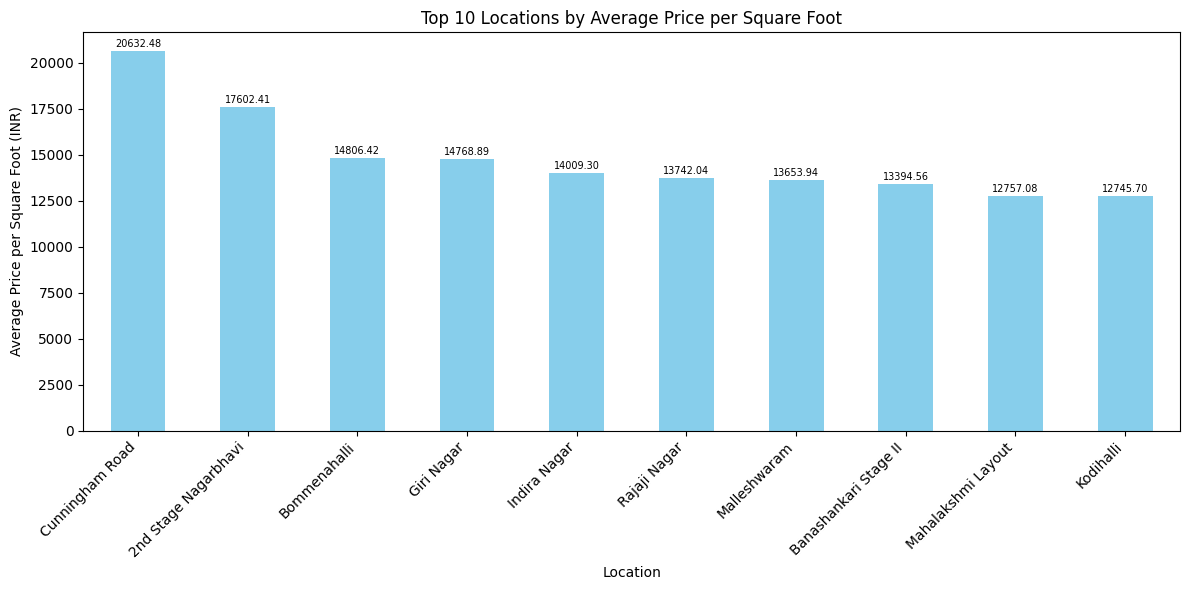

In [196]:
# Group by location and calculate mean price per square foot
location_price_per_sqft = df5.groupby('location')['price_per_sqft'].mean().sort_values(ascending=False).head(10)

# Plot the bar plot
plt.figure(figsize=(12, 6))
lb=location_price_per_sqft.plot(kind='bar', color='skyblue')
for p in lb.patches:
    lb.annotate(f'{p.get_height():.2f}',  # Display the height (value) with 2 decimal points
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top-center of the bar
                ha='center', va='center', 
                fontsize=7, color='black', 
                xytext=(0, 5),  # Offset the label slightly above the bar
                textcoords='offset points')
plt.title("Top 10 Locations by Average Price per Square Foot")
plt.xlabel("Location")
plt.ylabel("Average Price per Square Foot (INR)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

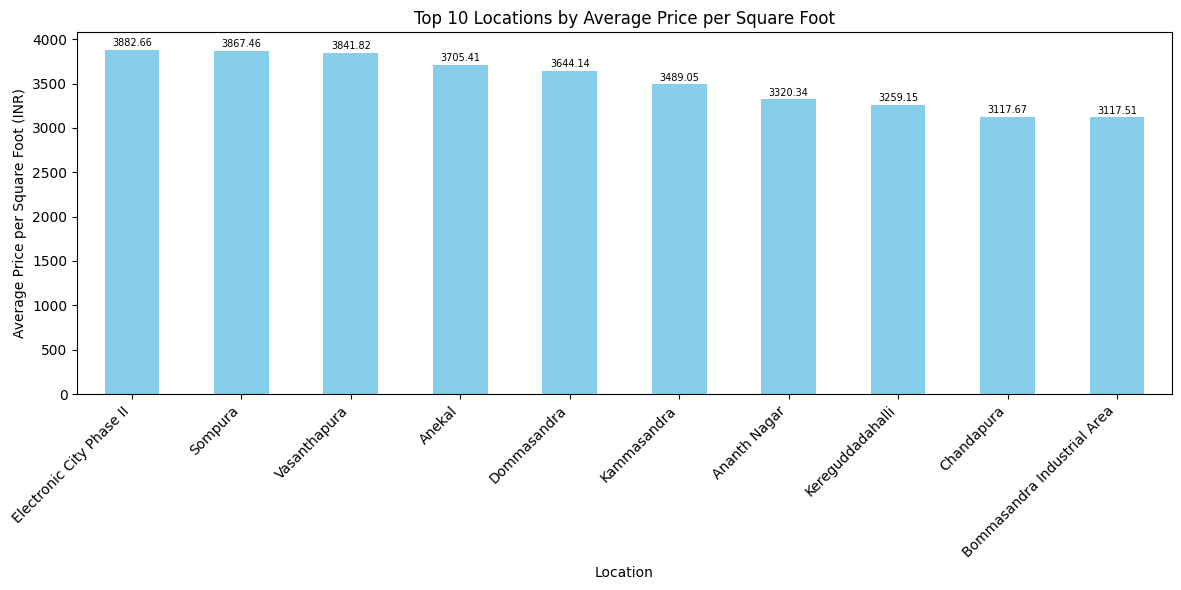

In [200]:
# Group by location and calculate mean price per square foot
location_price_per_sqft = df5.groupby('location')['price_per_sqft'].mean().sort_values(ascending=False).tail(10)

# Plot the bar plot
plt.figure(figsize=(12, 6))
lb=location_price_per_sqft.plot(kind='bar', color='skyblue')
for p in lb.patches:
    lb.annotate(f'{p.get_height():.2f}',  # Display the height (value) with 2 decimal points
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top-center of the bar
                ha='center', va='center', 
                fontsize=7, color='black', 
                xytext=(0, 5),  # Offset the label slightly above the bar
                textcoords='offset points')
plt.title("Top 10 Locations by Average Price per Square Foot")
plt.xlabel("Location")
plt.ylabel("Average Price per Square Foot (INR)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

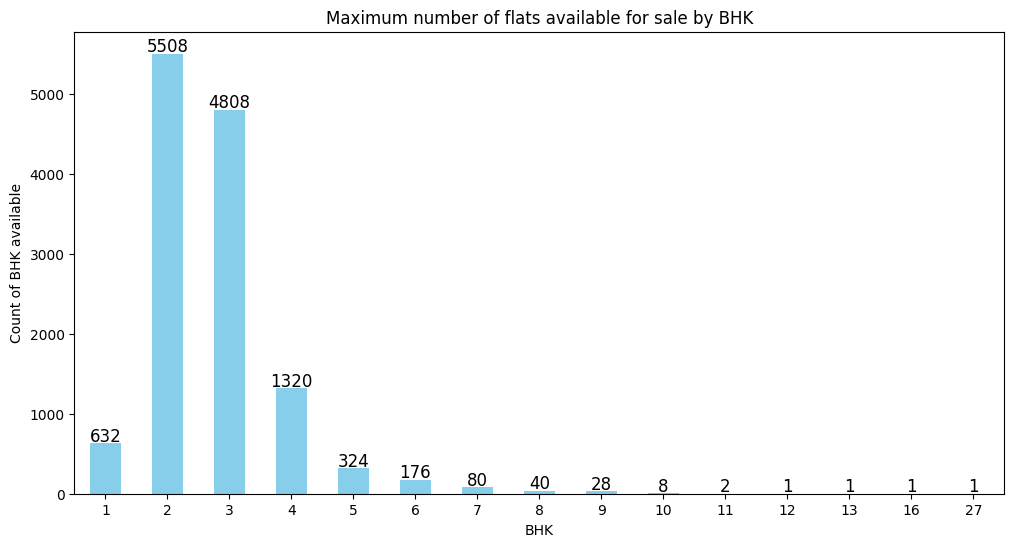

In [191]:
count = df5.groupby('bhk').size()  # Use .size() to get the count of rows for each BHK

# Plotting the bar chart
plt.figure(figsize=(12, 6))
ax = count.plot(kind='bar', color='skyblue')

# Adding data labels on top of each bar
for p in ax.patches:
    # p.get_height() gives the height of the bar (the count value)
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top center of the bar
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5),  # offset the label a little above the bar
                textcoords='offset points')

# Customizing the plot
plt.title('Maximum number of flats available for sale by BHK')
plt.xlabel('BHK')
plt.ylabel('Count of BHK available')
plt.xticks(rotation=0)  # Keeps the BHK labels horizontal
plt.show()

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [149]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                        532
Sarjapur  Road                    391
Electronic City                   302
Kanakpura Road                    264
Thanisandra                       234
                                 ... 
asha township, off hennur road      1
Escorts Colony                      1
Rahat Bagh                          1
Nagarbhavi  BDA Complex             1
Abshot Layout                       1
Name: count, Length: 1253, dtype: int64

In [150]:
location_stats.values.sum()

12930

In [151]:
len(location_stats[location_stats>10])

236

In [152]:
len(location_stats)

1253

In [153]:
len(location_stats[location_stats<=10])

1017

# Dimensionality Reduction

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [154]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Gunjur Palya                      10
Dodsworth Layout                  10
Sector 1 HSR Layout               10
Basapura                          10
Kalkere                           10
                                  ..
asha township, off hennur road     1
Escorts Colony                     1
Rahat Bagh                         1
Nagarbhavi  BDA Complex            1
Abshot Layout                      1
Name: count, Length: 1017, dtype: int64

In [155]:
len(df5.location.unique())

1253

In [156]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

237

In [157]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft,min_size
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606,474
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615,722
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556,598
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861,598
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000,474
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248,474
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101,722
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182,722
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275,598
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804,970


# Outlier Removal Using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [158]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft,min_size
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804,970
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810,970
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296,1218
149,other,6 Bedroom,1034.0,5.0,185.0,6,17891.682785,970
170,other,6 BHK,1300.0,6.0,99.0,6,7615.384615,970


Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [159]:
df5.shape

(12930, 8)

In [160]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12453, 8)

Outlier Removal Using Standard Deviation and Mean

In [161]:
df6.price_per_sqft.describe()

count     12453.000000
mean       6308.941317
std        4168.461045
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [162]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10248, 8)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

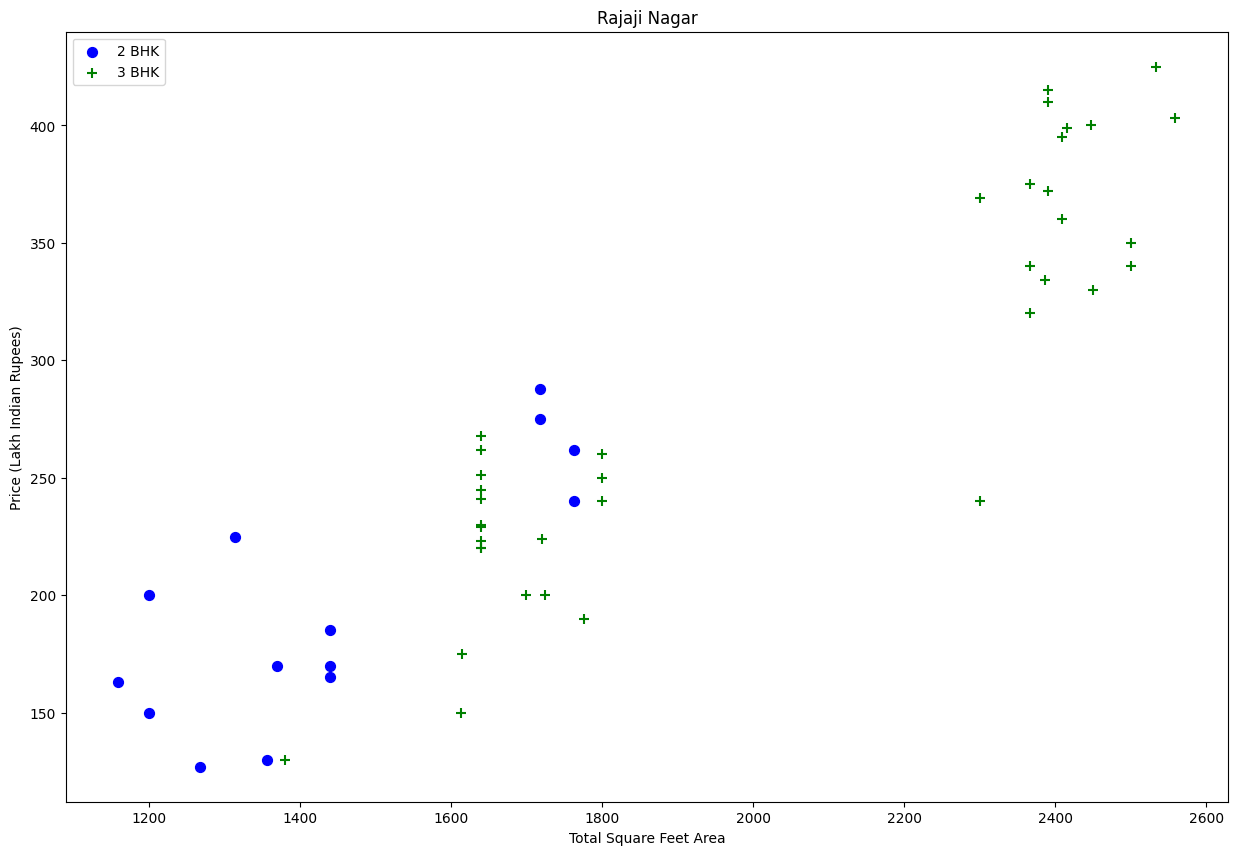

In [163]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

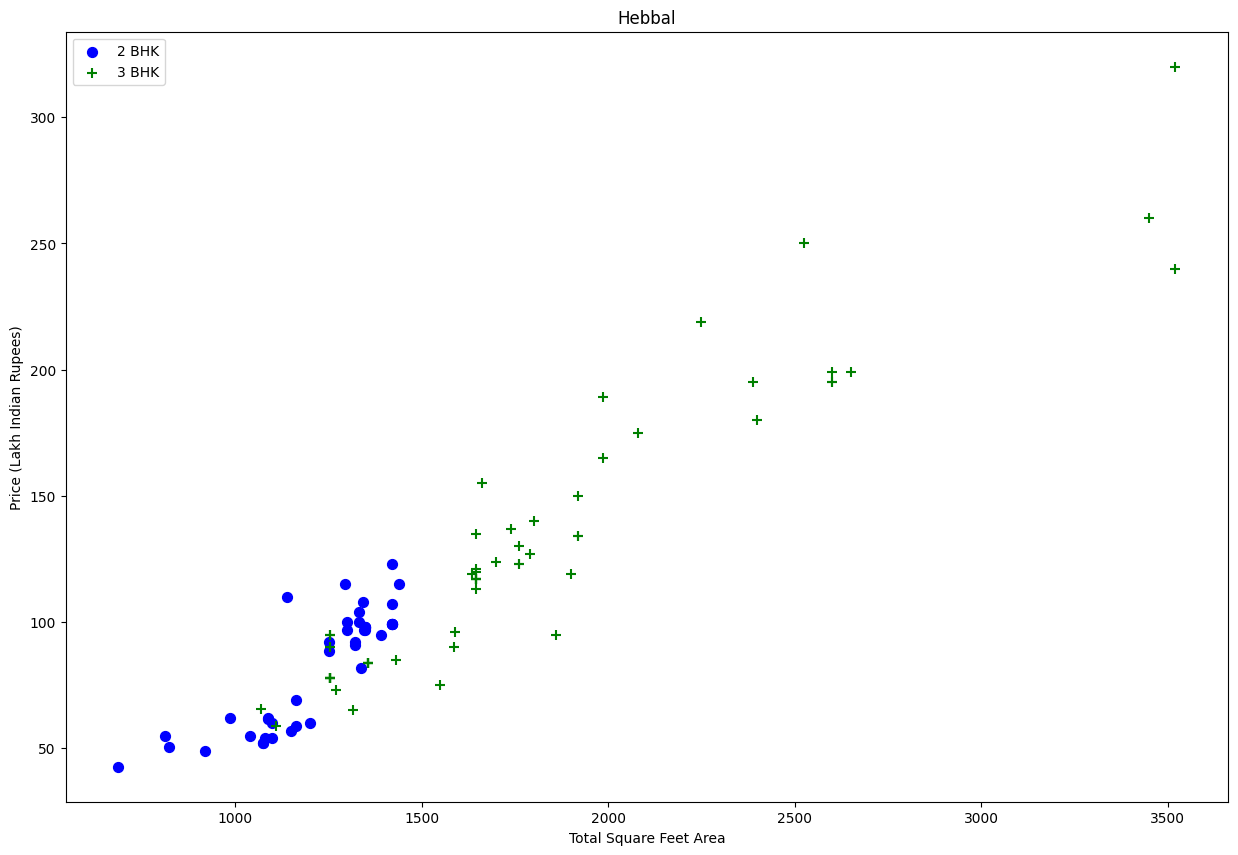

In [164]:
plot_scatter_chart(df7,"Hebbal")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

{

    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
        
    },
    
}

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [165]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7302, 8)

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

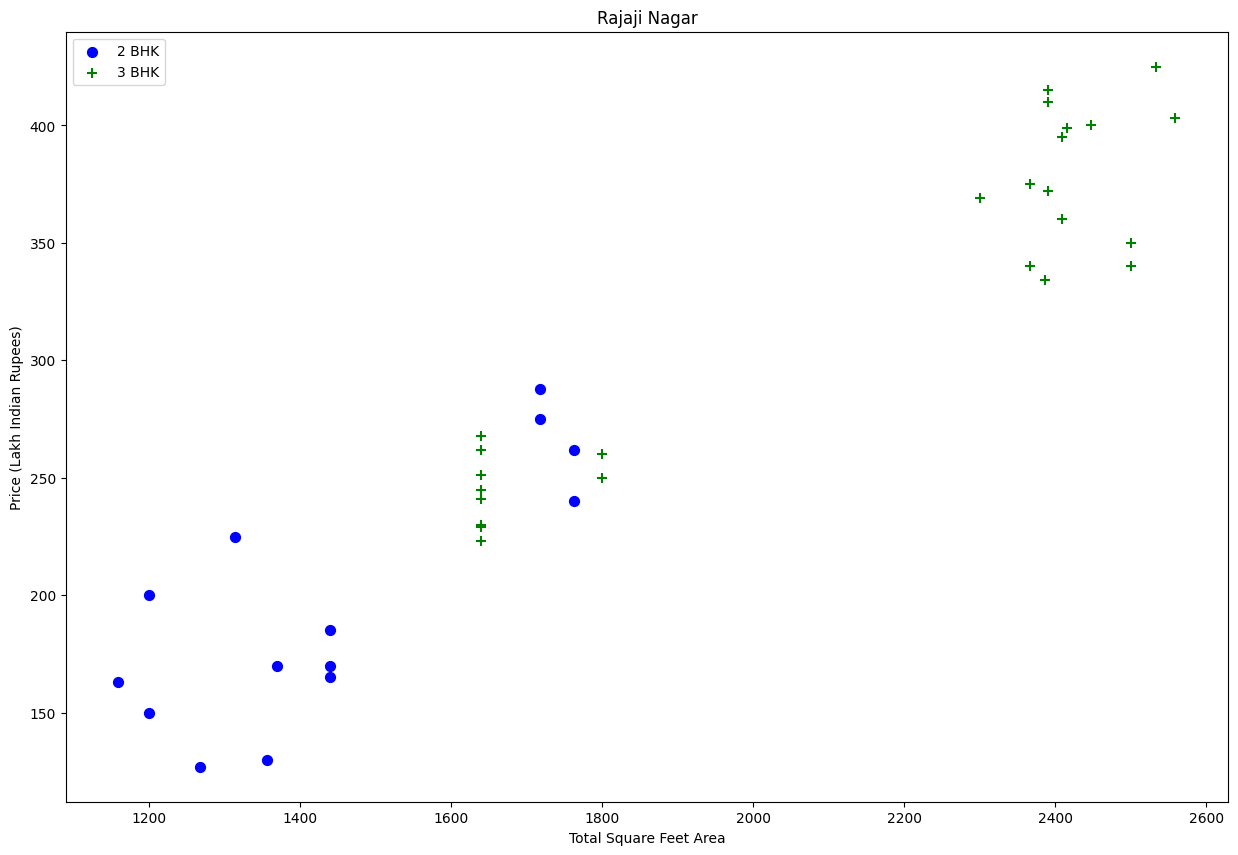

In [166]:
plot_scatter_chart(df8,"Rajaji Nagar")

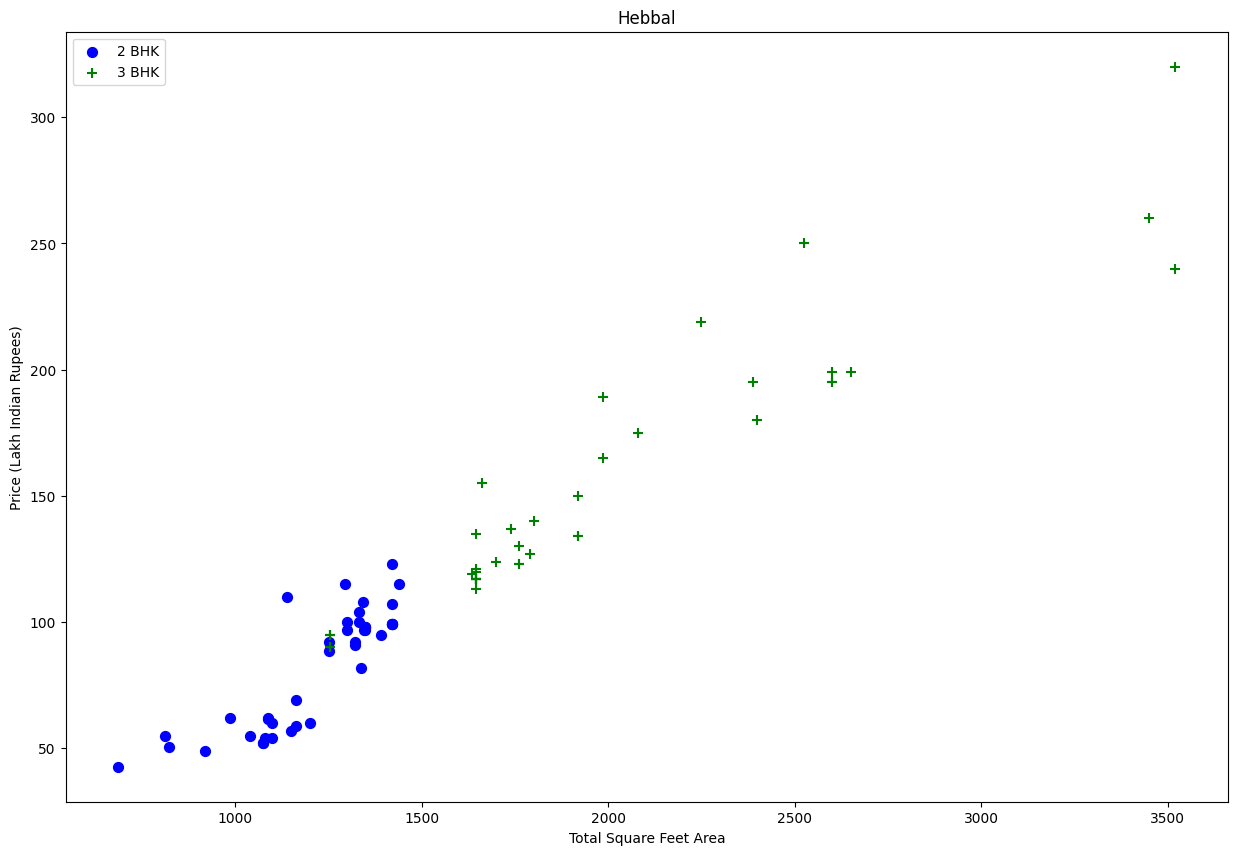

In [167]:
plot_scatter_chart(df8,"Hebbal")

Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

Text(0, 0.5, 'Count')

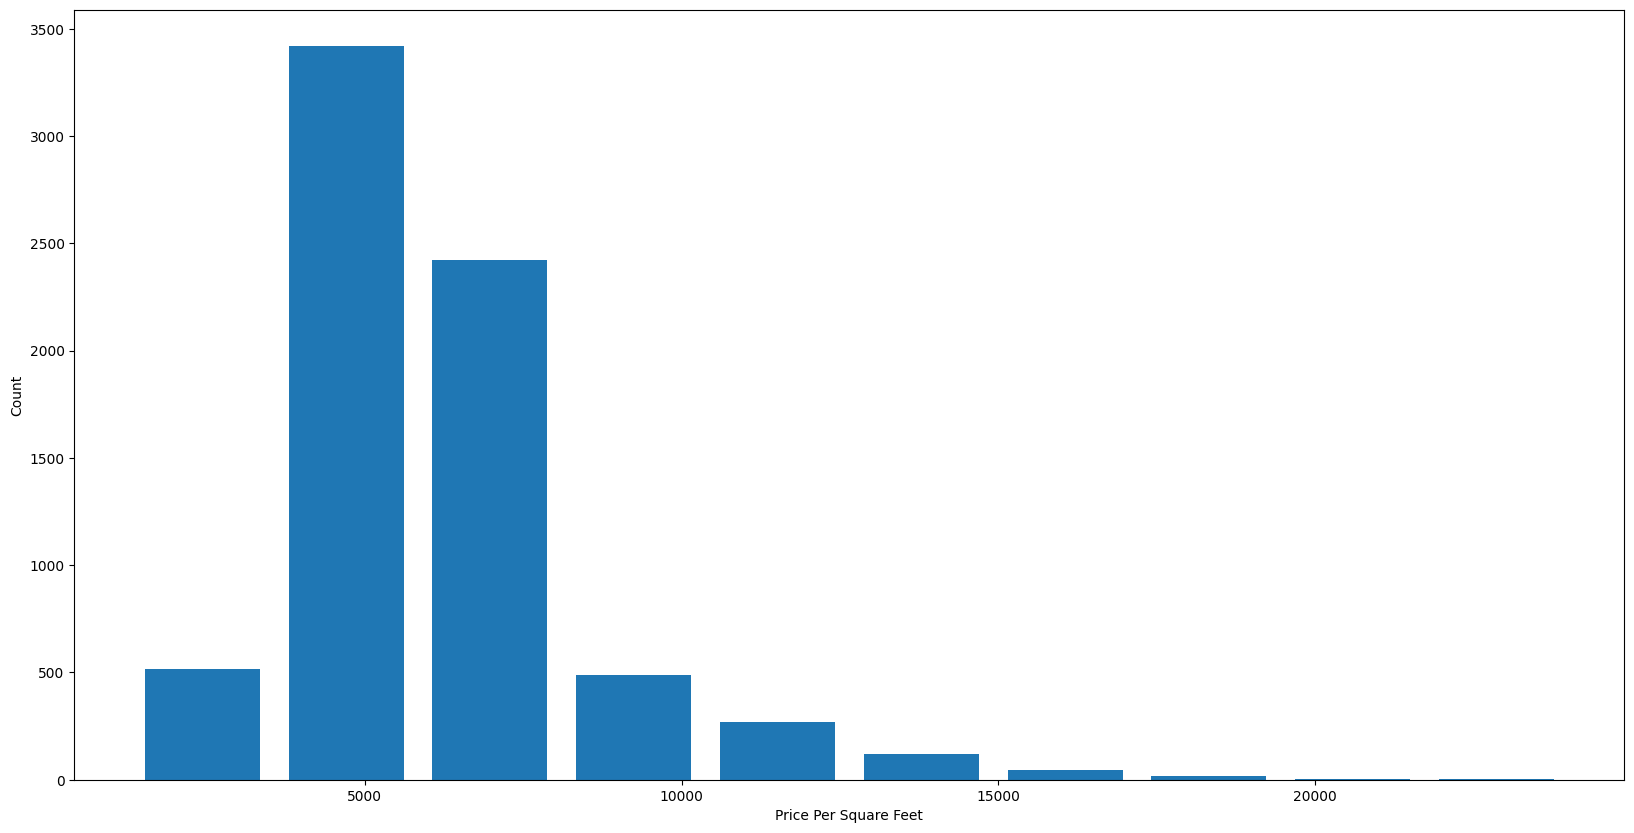

In [168]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [169]:
df9 = df8.drop(['size','price_per_sqft'],axis='columns')
df9.head(3)

,location,total_sqft,bath,price,bhk,min_size
0,1st Block Jayanagar,2850.0,4.0,428.0,4,722
1,1st Block Jayanagar,1630.0,3.0,194.0,3,598
2,1st Block Jayanagar,1875.0,2.0,235.0,3,598


# Use One Hot Encoding For Location

In [170]:
dummies = pd.get_dummies(df9.location,dtype=int)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [171]:
df10 = pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk,min_size,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vasanthapura,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,722,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,598,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,598,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,598,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,474,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
df11 = df10.drop('location',axis='columns')
df11.head(2)

,total_sqft,bath,price,bhk,min_size,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vasanthapura,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,722,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,598,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
X = df11.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,min_size,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vasanthapura,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,722,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,598,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,598,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
y = df11.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [176]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8658186531443361

Use K Fold cross validation to measure accuracy of our LinearRegression model

In [177]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.87921587, 0.83305424, 0.85243138, 0.85988415, 0.86837273])

We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

# Find best model using GridSearchCV


In [178]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'copy_X': [True, False],
                'fit_intercept':[True, False],
                'positive':[True,False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\HP

,model,best_score,best_params
0,linear_regression,0.858592,"{'copy_X': True, 'fit_intercept': False, 'posi..."
1,lasso,0.704984,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.755554,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

# Test the model for few properties

In [179]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [180]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


94.83039778326433

In [181]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


99.34824947599175

In [182]:
predict_price('Indira Nagar',1000, 2, 2)

C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


204.8112396075797

In [183]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Users\HP\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


209.32909130030708

# Export the tested model to a pickle file

In [184]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

# Export location and column information to a file that will be useful later on in our prediction application


In [185]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))